# Fine-tune MaskFormer for semantic segmentation

In this notebook, we'll show how to fine-tune the model on a semantic segmentation dataset. In semantic segmentation, the goal for the model is to segment general semantic categories in an image, like "building", "people", "sky". No distinction is made between individual instances of a certain category, i.e. we just come up with one mask for the "people" category for instance, not for the individual persons.

Make sure to run this notebook on a GPU.

## Set-up environment

First, we install the necessary libraries. 🤗, what else? Oh yes we'll also use [Albumentations](https://albumentations.ai/), for some data augmentation to make the model more robust. You can of course use any data augmentation library of your choice.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00


In [3]:
!pip install -q albumentations

In [23]:
!pip install huggingface_hub

In [24]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [9]:
import zipfile
# Path to the ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/SunFlower500-Jesi.v2i.coco.zip'  # Replace with your file's pat

import os
os.mkdir(os.path.join('/content/drive/MyDrive/Colab Notebooks/', 'Sunflower'))

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/Sunflower/')  # Replace with your destination directory

## Load data

THESE ARE THE DATA PRECPROCESSING STEPS DONE TO CONVERT IMAGES AND A COCO ANNOTATIONS IN JSON TO MASKED ANNOTATED IMAGES AND THEN STORING IT TO THE HUGGINGFACE REPOSITORY

In [15]:
import cv2
import numpy as np
import os
import json

def create_mask_from_bboxes(bboxes, image_height, image_width, mask_save_path):
    """
    Creates a mask from bounding box coordinates and saves it as an image.

    :param bboxes: List of bounding boxes, each box is [x_min, y_min, width, height].
    :param image_height: Height of the mask (and the original image).
    :param image_width: Width of the mask (and the original image).
    :param mask_save_path: Path to save the mask image.
    """
    # Create an empty mask.
    mask = np.zeros((image_height, image_width), dtype=np.uint8)

    for bbox in bboxes:
        x_min, y_min, width, height = map(int, bbox)
        x_max = x_min + width
        y_max = y_min + height

        # Draw rectangle on the mask.
        cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), 1, -1) # -1 fills the rectangle

    # Save the mask
    cv2.imwrite(mask_save_path, mask)

# Load the COCO format JSON file
file_path = '/content/drive/MyDrive/Colab Notebooks/Sunflower/train_a/_annotations.coco.json'

with open(file_path, 'r') as file:
    coco_data = json.load(file)

# Assuming 'images_info' and 'annotations_info' are extracted as before
images_info = coco_data.get('images', [])
annotations_info = coco_data.get('annotations', [])

if images_info and annotations_info:
    # Create the 'annotated' folder if it doesn't exist
    annotated_folder = '/content/drive/MyDrive/Colab Notebooks/Sunflower/train/annotated/'
    os.makedirs(annotated_folder, exist_ok=True)

    for image_info in images_info:
        image_id = image_info['id']
        image_height = image_info['height']
        image_width = image_info['width']

        # Filter annotations for the current image
        image_annotations = [ann for ann in annotations_info if ann['image_id'] == image_id]

        # Extract bounding box coordinates
        bboxes = [ann['bbox'] for ann in image_annotations if ann['bbox']]

        # Generate the mask save path based on the image id
        mask_save_path = f'{annotated_folder}annotation_{image_id}.png'

        # Create and save the mask
        create_mask_from_bboxes(bboxes, image_height, image_width, mask_save_path)

In [16]:
import cv2
import numpy as np
import os
import json

def create_mask_from_bboxes(bboxes, image_height, image_width, mask_save_path):
    """
    Creates a mask from bounding box coordinates and saves it as an image.

    :param bboxes: List of bounding boxes, each box is [x_min, y_min, width, height].
    :param image_height: Height of the mask (and the original image).
    :param image_width: Width of the mask (and the original image).
    :param mask_save_path: Path to save the mask image.
    """
    # Create an empty mask.
    mask = np.zeros((image_height, image_width), dtype=np.uint8)

    for bbox in bboxes:
        x_min, y_min, width, height = map(int, bbox)
        x_max = x_min + width
        y_max = y_min + height

        # Draw rectangle on the mask.
        cv2.rectangle(mask, (x_min, y_min), (x_max, y_max), 1, -1) # -1 fills the rectangle

    # Save the mask
    cv2.imwrite(mask_save_path, mask)

# Load the COCO format JSON file for validation
file_path = '/content/drive/MyDrive/Colab Notebooks/Sunflower/valid_a/_annotations.coco.json'

with open(file_path, 'r') as file:
    coco_data = json.load(file)

# Assuming 'images_info' and 'annotations_info' are extracted as before
images_info = coco_data.get('images', [])
annotations_info = coco_data.get('annotations', [])

if images_info and annotations_info:
    # Create the 'annotated' folder if it doesn't exist for validation
    annotated_folder = '/content/drive/MyDrive/Colab Notebooks/Sunflower/valid/annotated/'
    os.makedirs(annotated_folder, exist_ok=True)

    for image_info in images_info:
        image_id = image_info['id']
        image_height = image_info['height']
        image_width = image_info['width']

        # Filter annotations for the current image
        image_annotations = [ann for ann in annotations_info if ann['image_id'] == image_id]

        # Extract bounding box coordinates
        bboxes = [ann['bbox'] for ann in image_annotations if ann['bbox']]

        # Generate the mask save path based on the image id for validation
        mask_save_path = f'{annotated_folder}annotation_{image_id}.png'

        # Create and save the mask
        create_mask_from_bboxes(bboxes, image_height, image_width, mask_save_path)

In [17]:
# Load the COCO format JSON file for the test dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/Sunflower/test_a/_annotations.coco.json'

with open(file_path, 'r') as file:
    coco_data = json.load(file)

# Assuming 'images_info' and 'annotations_info' are extracted as before
images_info = coco_data.get('images', [])
annotations_info = coco_data.get('annotations', [])

if images_info and annotations_info:
    # Create the 'annotated' folder if it doesn't exist for the test dataset
    annotated_folder = '/content/drive/MyDrive/Colab Notebooks/Sunflower/test/annotated/'
    os.makedirs(annotated_folder, exist_ok=True)

    for image_info in images_info:
        image_id = image_info['id']
        image_height = image_info['height']
        image_width = image_info['width']

        # Filter annotations for the current image
        image_annotations = [ann for ann in annotations_info if ann['image_id'] == image_id]

        # Extract bounding box coordinates
        bboxes = [ann['bbox'] for ann in image_annotations if ann['bbox']]

        # Generate the mask save path based on the image id for the test dataset
        mask_save_path = f'{annotated_folder}annotation_{image_id}.png'

        # Create and save the mask
        create_mask_from_bboxes(bboxes, image_height, image_width, mask_save_path)

In [18]:
import os

image_folder_train = '/content/drive/MyDrive/Colab Notebooks/Sunflower/train/'
all_files = os.listdir(image_folder_train)

image_paths_train = [os.path.join(image_folder_train, file) for file in all_files if file.lower().endswith('.jpg')]

annotated_folder_train = '/content/drive/MyDrive/Colab Notebooks/Sunflower/train/annotated/'
all_label_files = os.listdir(annotated_folder_train)
label_paths_train = [os.path.join(annotated_folder_train, file) for file in all_label_files if file.lower().endswith('.png')]

In [19]:
import os

image_folder_valid = '/content/drive/MyDrive/Colab Notebooks/Sunflower/valid/'

all_files_valid = os.listdir(image_folder_valid)
image_paths_valid = [os.path.join(image_folder_valid, file) for file in all_files_valid if file.lower().endswith('.jpg')]

annotated_folder_valid = '/content/drive/MyDrive/Colab Notebooks/Sunflower/valid/annotated/'

all_label_files_valid = os.listdir(annotated_folder_valid)
label_paths_valid = [os.path.join(annotated_folder_valid, file) for file in all_label_files_valid if file.lower().endswith('.png')]

In [20]:
image_folder_test = '/content/drive/MyDrive/Colab Notebooks/Sunflower/test/'

all_files_test = os.listdir(image_folder_test)
image_paths_test = [os.path.join(image_folder_test, file) for file in all_files_test if file.lower().endswith('.jpg')]

annotated_folder_test = '/content/drive/MyDrive/Colab Notebooks/Sunflower/test/annotated/'

all_label_files_test = os.listdir(annotated_folder_test)
label_paths_test = [os.path.join(annotated_folder_test, file) for file in all_label_files_test if file.lower().endswith('.png')]

In [21]:
from datasets import Dataset, DatasetDict, Image

def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

# step 1: create Dataset objects
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_valid, label_paths_valid)
test_dataset = create_dataset(image_paths_test, label_paths_test)

# step 2: create DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset,
  }
)

In [25]:
# step 3: push to hub (assumes you have ran the huggingface-cli login command in a terminal/notebook)
dataset.push_to_hub("axdhiith/SunflowerWeed")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

THIS IS HOW I RETRIEVE THE DATASET FROM THE HUGGINGFACE REPOSITORY

In [26]:
from datasets import load_dataset

dataset = load_dataset("axdhiith/SunflowerWeed")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/150 [00:00<?, ? examples/s]

In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 150
    })
})

In [28]:
train_ds = dataset["train"]
test_ds = dataset["test"]
valid_ds = dataset["validation"]

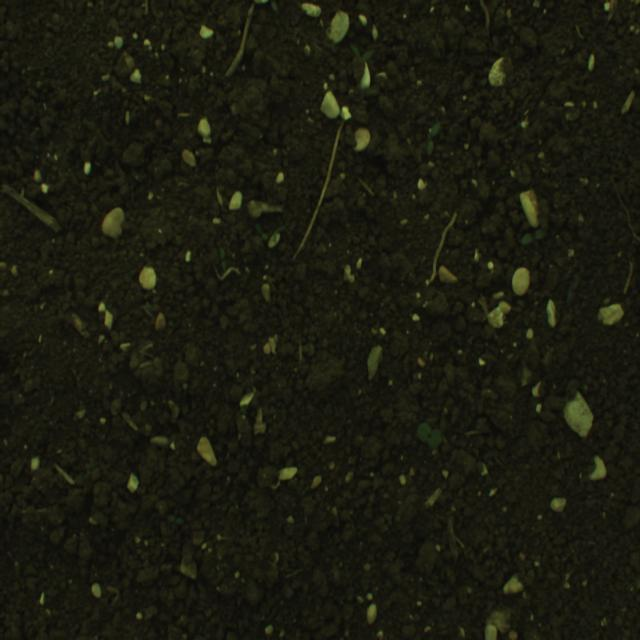

In [29]:
# let's look at one example (images are pretty high resolution)
example = train_ds[0]
image = example['image']
image

In [30]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Let's look at the semantic categories in this particular example.

In [31]:
np.unique(segmentation_map)

array([0, 1], dtype=uint8)

In [32]:
import json
# simple example
id2label = {0: 'weed-crop', 1: 'Crop', 2: 'Weed'}
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)

In [ ]:
# from huggingface_hub import hf_hub_download
# import json

# repo_id = f"axdhiith/SugarbeetWeed"
# filename = "id2label.json"
# id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
# id2label = {int(k):v for k,v in id2label.items()}
# print(id2label)

In [33]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['weed-crop', 'Crop']


Let's visualize it: ------------------------------------------------------------THIS DIDNT WORK

In [34]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

palette = color_palette()

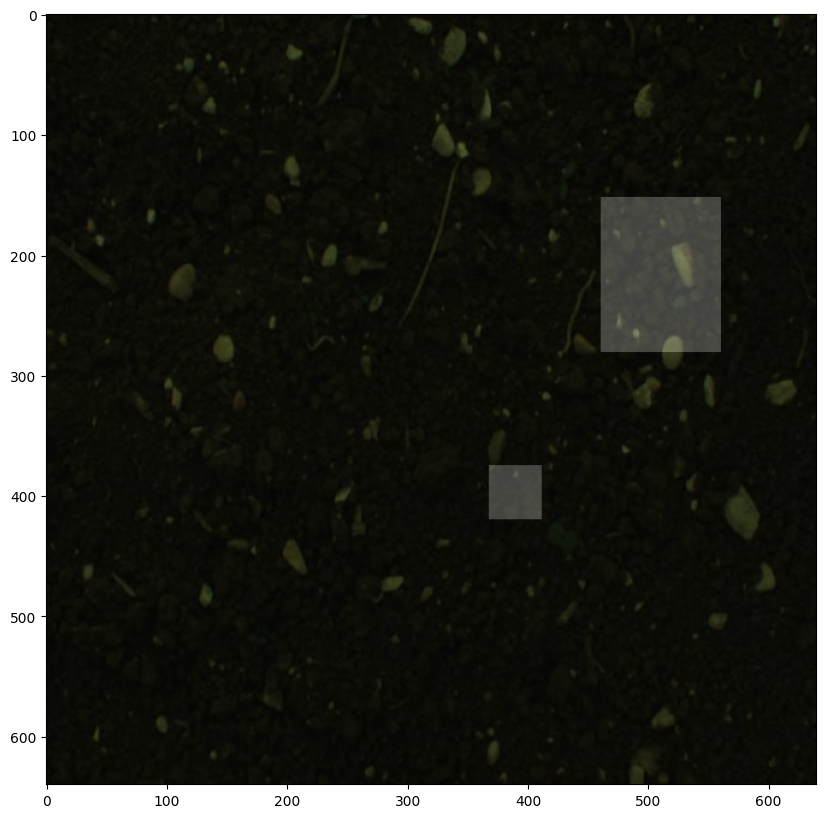

In [35]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

## Create PyTorch Dataset

Next, we create a standard PyTorch dataset. Each item of the dataset consists of the image and corresponding ground truth segmentation map. We also include the original image + map (before preprocessing) in order to compute metrics like mIoU.

In [36]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

The dataset accepts image transformations which can be applied on both the image and the map. Here we use Albumentations, to resize, randomly crop + flip and normalize them. Data augmentation is a widely used technique in computer vision to make the model more robust.

In [37]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [38]:
image, segmentation_map, _, _ = train_dataset[0]
print(image.shape)
print(segmentation_map.shape)

(3, 512, 512)
(512, 512)


A great way to check that our data augmentations are working well is by denormalizing the pixel values. So here we perform the inverse operation of Albumentations' normalize method and visualize the image:

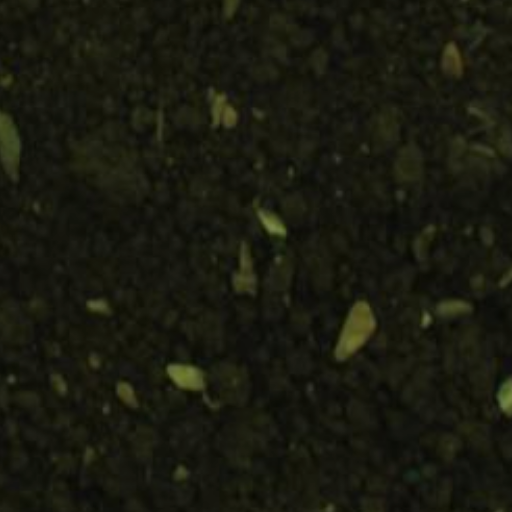

In [39]:
from PIL import Image

unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

This looks ok. Let's also verify whether the corresponding ground truth map is still ok.

In [40]:
segmentation_map.shape

(512, 512)

In [41]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['weed-crop', 'Crop']


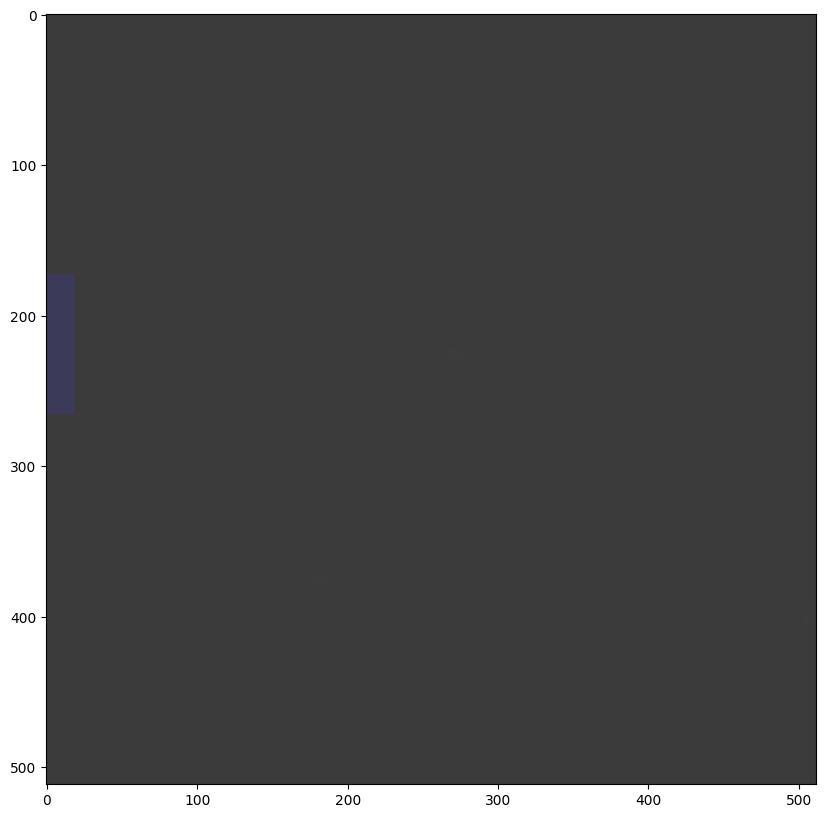

In [42]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.moveaxis(image, 0, -1) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Ok great!

## Create PyTorch DataLoaders

Next we create PyTorch DataLoaders, which allow us to get batches of the dataset. For that we define a custom so-called "collate function", which PyTorch allows you to do. It's in this function that we'll use the preprocessor of MaskFormer, to turn the images + maps into the format that MaskFormer expects.

It's here that we make the paradigm shift that the MaskFormer authors introduced: the "per-pixel" annotations of the segmentation map will be turned into a set of binary masks and corresponding labels. It's this format on which we can train MaskFormer. MaskFormer namely casts any image segmentation task to this format.

In [43]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

In [44]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = list(inputs[0])  # Convert tuple to list
    segmentation_maps = list(inputs[1])  # Convert tuple to list
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

## Verify data (!!)

Next, it's ALWAYS very important to check whether the data you feed to the model actually makes sense. It's one of the main principles of [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/), if you wanna debug your neural networks.

Let's check the first batch, and its content.

In [45]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
mask_labels torch.Size([1, 512, 512])
class_labels torch.Size([1])
original_images (640, 640, 3)
original_segmentation_maps (640, 640)


In [46]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 512, 512)

Again, let's denormalize an image and see what we got.

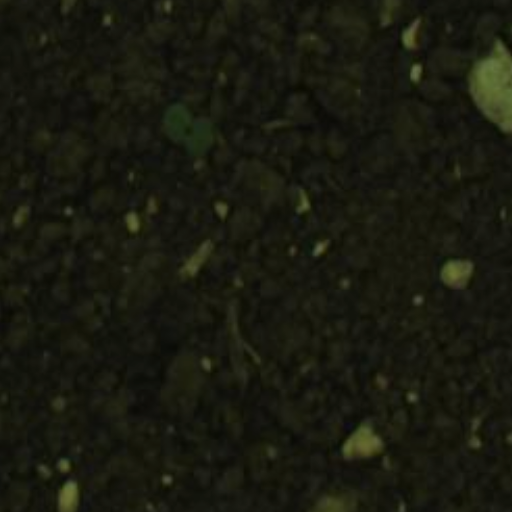

In [47]:
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Let's verify the corresponding binary masks + class labels.

In [48]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['Crop']


In [49]:
# verify mask labels
batch["mask_labels"][0].shape

torch.Size([1, 512, 512])

In [50]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: Crop


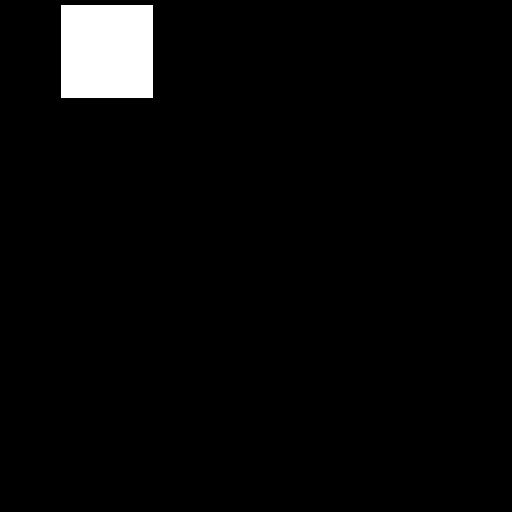

In [51]:
visualize_mask(labels, "Crop")

## Define model

Next, we define the model. We equip the model with pretrained weights from the 🤗 hub. We will replace only the classification head. For that we provide the id2label mapping, and specify to ignore mismatches keys to replace the already fine-tuned classification head.

In [52]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([4]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


See also the warning here: it's telling us that we are only replacing the class_predictor, which makes sense. As it's the only parameters that we will train from scratch.

## Compute initial loss

Another good way to debug neural networks is to verify the initial loss, see if it makes sense.

In [53]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [54]:
outputs.loss

tensor([3.1025], grad_fn=<AddBackward0>)

## Train the model

It's time to train the model! We'll use the mIoU metric to track progress.

In [55]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow

In [56]:
import evaluate

metric = evaluate.load("mean_iou")

In [57]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(5):
  print("Epoch:", epoch)
  model.train()
  # for idx, batch in enumerate(tqdm(train_dataloader)):
  if len(train_dataloader) > 0:
    for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 5:
      break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

Epoch: 0


  0%|          | 0/150 [00:00<?, ?it/s]

Loss: 1.5490918159484863


ValueError: ignored

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of a test batch.

In [58]:
# let's take the first test batch
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
mask_labels 2
class_labels 2
original_images 2
original_segmentation_maps 2


In [59]:
# forward pass
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [60]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

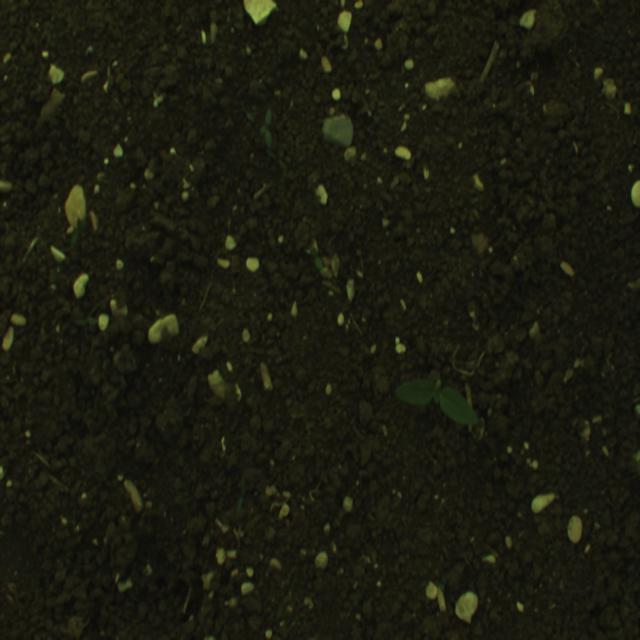

In [61]:
image = batch["original_images"][0]
Image.fromarray(image)

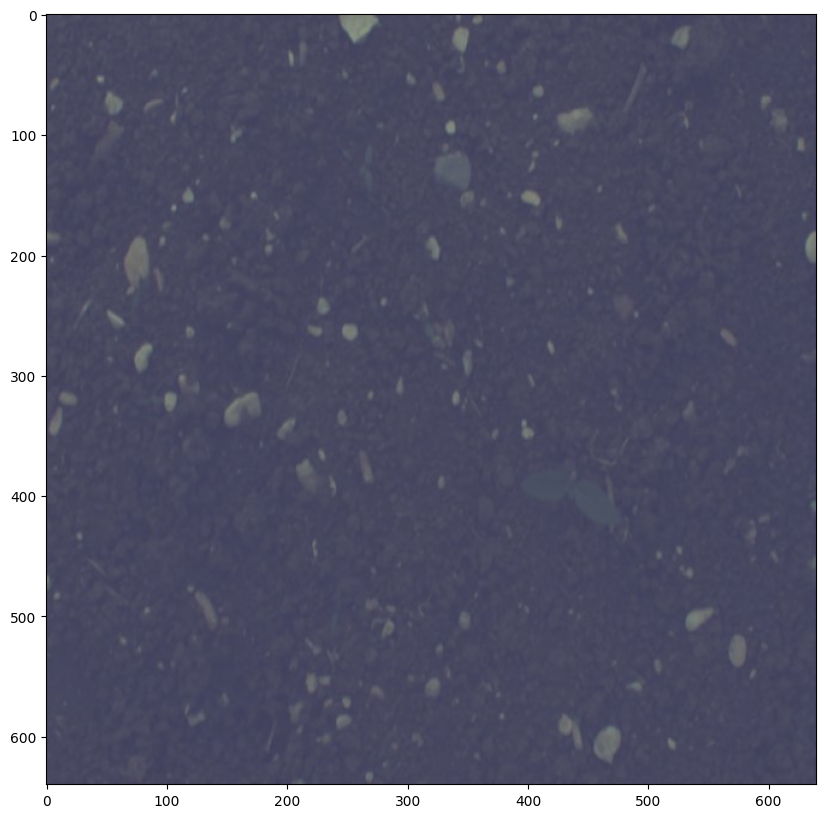

In [62]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare to the ground truth:

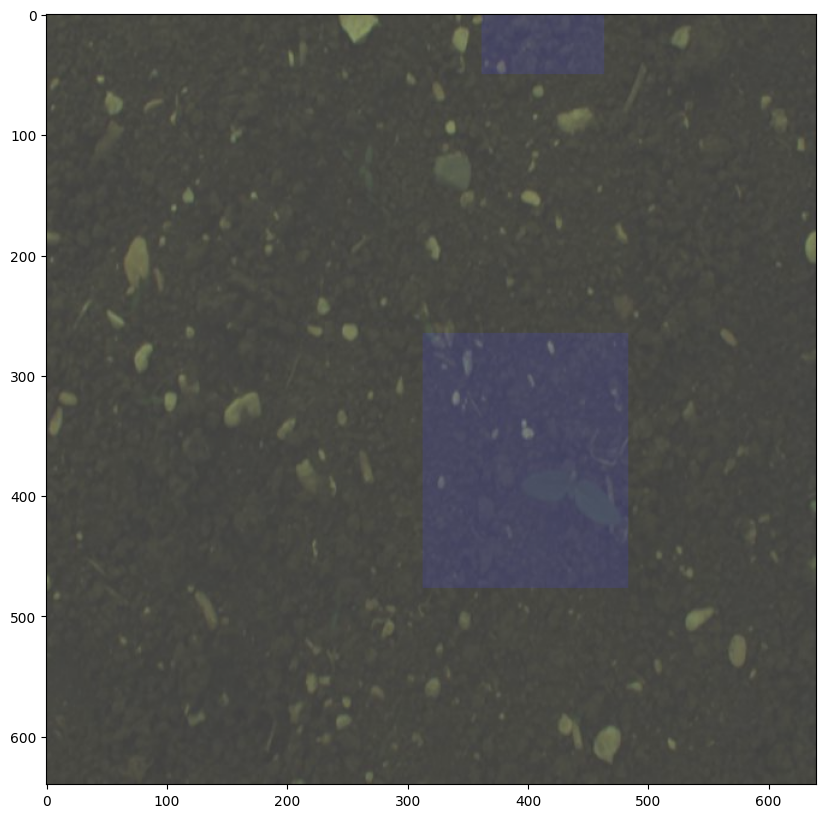

In [63]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][0]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

I could not train the model completely due to the lack of computational resources. Also, there may have been some issue with the segmentation_maps generated. I tried above and beyond but could not succeed :(